# Maintenance Planning

Assume at factory is operating over a planning period from $1$ to $T$ days.  On day $t$ the factory makes a profit $c[t]$ which is known in advance. The factory also needs to shut down for at least two maintenance periods during the planning period.  Once started, a maintenance period takes at least $M$ days to finish.

Find a maintenance schedule that allows the maximum profit to be produced.

In [0]:
%%capture
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

## Modeling

Define boolean variables

\begin{align*}
x_t & = 1 \implies \mbox{factory is operating on day }t \\
y_t & = 1 \implies \mbox{maintenance starts on day }t
\end{align*}

Objective 

\begin{align*}
\mbox{Profit} & = \max_{x, y, z} \sum_{t=1}^T c_t x_t
\end{align*}

Number of maintenance periods $P$

\begin{align*}
\sum_{t=1}^{T-M+1} y_t &  = P
\end{align*}

No more than on maintenance start in an M day period

\begin{align*}
\sum_{s=t}^{t+M-1}y_s & \leq 1 \qquad \forall t = 1, 2, \ldots, T-M
\end{align*}

Factory stays down for M days for a maintenance period

$$y_t + x_{t+s} \leq 1 \qquad \forall t = 1, 2, \ldots, T-M+1 \quad \forall s = t, t+1, \ldots, t+M-1$$



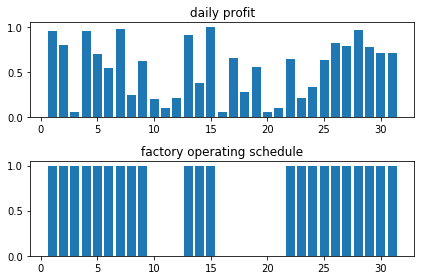

In [195]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np

T = 31        # planning period from 1..T
M = 3        # length of maintenance period
P = 3        # number of maintenance periods
c = {k:np.random.uniform() for k in range(1, T+1)}

m = pyo.ConcreteModel()

m.T = pyo.RangeSet(1, T)
m.c = pyo.Param(m.T, initialize = c)
m.x = pyo.Var(m.T, domain=pyo.Binary)     # m.x[t] == 1 factory up from t-1 to t
m.y = pyo.Var(m.T, domain=pyo.Binary)     # m.y[t] == 1 first day of a maintenance period

# objective
m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)

# required number P of maintenance starts
m.ystarts = pyo.Constraint(expr = sum(m.y[t] for t in range(1, T-M+2)) == P)

# only one maintenance start in M days
m.ycons = pyo.ConstraintList()
for t in range(1, T-M+2):
    m.ycons.add(sum(m.y[s] for s in range(t, min(t+M, T+M-1))) <= 1)

# factory stays down for M days following a maintenance start
m.state = pyo.ConstraintList()
for t in range(1, T-M+2):
  for s in range(t, t+M):
    m.state.add(m.y[t] + m.x[s] <= 1)

# solve
pyo.SolverFactory('cbc').solve(m)

# plot
fig,ax = plt.subplots(2,1)
ax[0].bar([t for t in m.T], [m.c[t] for t in m.T])
ax[0].set_title('daily profit')
ax[1].bar([t for t in m.T], [m.x[t]() for t in m.T])
ax[1].set_title('factory operating schedule')
plt.tight_layout()